# Using pytorch to make linear regression model from scratch

## Import libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
SEED = 1234
NUM_SAMPLES = 50

In [107]:
import torch

In [108]:
# Set seed for reproducibility
torch.manual_seed(SEED)

## Load data

In [109]:
# Generate synthetic data
def generate_data(num_samples):
    """Generate dummy data for linear regression."""
    X = np.array(range(num_samples))
    random_noise = np.random.uniform(-10, 20, size=num_samples)
    y = 3.5*X + random_noise # add some noise
    return X, y

# Generate random (linear) data
X, y = generate_data(num_samples=NUM_SAMPLES)
data = np.vstack([X, y]).T
print (data[:5])

[[ 0.         14.76655552]
 [ 1.         -4.4325097 ]
 [ 2.         21.08601705]
 [ 3.          1.08319889]
 [ 4.         15.32366286]]


In [110]:
# Load into a Pandas DataFrame
df = pd.DataFrame(data, columns=["X", "y"])
X = df[["X"]].values
y = df[["y"]].values
df.head()

,X,y
0,0.0,14.766556
1,1.0,-4.432510
2,2.0,21.086017
3,3.0,1.083199
4,4.0,15.323663


## Split dataset

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [113]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE)

In [114]:
X_train.shape, y_train.shape

((35, 1), (35, 1))

In [115]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 35 (0.70)
remaining: 15 (0.30)


In [116]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [117]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 35 (0.70)
val: 7 (0.14)
test: 8 (0.16)


## Standardize data

In [118]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train.reshape(-1, 1))
y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

In [119]:
# Apply scaler on training and test data
X_train = X_scaler.transform(X_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1))
X_val = X_scaler.transform(X_val.reshape(-1, 1))
y_val = y_scaler.transform(y_val.reshape(-1, 1))
X_test = X_scaler.transform(X_test.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

In [120]:
# Check (means should be ~0 and std should be ~1)
print (f"mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")


mean: -0.3, std: 0.8
mean: -0.3, std: 0.9


## Weight

In [121]:
from torch import nn

In [122]:
INPUT_DIM = X_train.shape[1] # X is 1-dimensional
OUTPUT_DIM = y_train.shape[1] # y is 1-dimensional

In [123]:
# Inputs
N = 3 # num samples
x = torch.randn(N, INPUT_DIM)
print (x.shape)
print (x.numpy())

torch.Size([3, 1])
[[ 0.04613046]
 [ 0.40240282]
 [-1.0115291 ]]


In [124]:
# Weights
m = nn.Linear(INPUT_DIM, OUTPUT_DIM)
print (m)
print (f"weights ({m.weight.shape}): {m.weight[0][0]}")
print (f"bias ({m.bias.shape}): {m.bias[0]}")

Linear(in_features=1, out_features=1, bias=True)
weights (torch.Size([1, 1])): 0.34761226177215576
bias (torch.Size([1])): -0.3370760679244995


In [125]:
# Forward pass
z = m(x)
print (z.shape)
print (z.detach().numpy())

torch.Size([3, 1])
[[-0.32104054]
 [-0.19719592]
 [-0.68869597]]


## Model

In [126]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
    
    def forward(self, x_in):
        y_pred = self.fc1(x_in)
        return y_pred

In [127]:
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

print(model.named_parameters)

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)>


## Loss function

In [128]:
loss_fn = nn.MSELoss()

# test
y_pred = torch.Tensor([0., 0., 1., 1.])
y_true =  torch.Tensor([1., 1., 1., 0.])
loss = loss_fn(y_pred, y_true)
print("Loss: ", loss.numpy())

Loss:  0.75


## Optimizer
optimize hyperparameters just like how we calculate gradients and update weights in `linear_regression.ipynb`

In [129]:
LEARNING_RATE = 1e-1

In [130]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [131]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [132]:
NUM_EPOCHS = 100

In [133]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0:
        print (f"Epoch: {epoch} | loss: {loss:.2f}")


Epoch: 0 | loss: 0.22
Epoch: 20 | loss: 0.04
Epoch: 40 | loss: 0.03
Epoch: 60 | loss: 0.03
Epoch: 80 | loss: 0.03


## Evaluation

In [134]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [135]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f"train_error: {train_error:.2f}")
print(f"test_error: {test_error:.2f}")

train_error: 0.03
test_error: 0.02


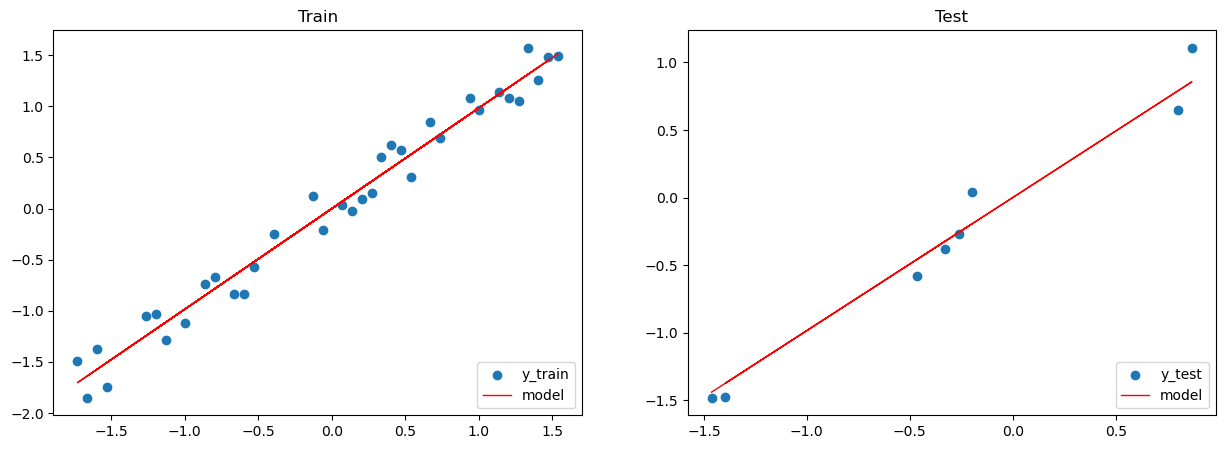

In [136]:
# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label="y_train")
plt.plot(X_train, pred_train.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")
plt.legend(loc="lower right")

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")
plt.legend(loc="lower right")

# Show plots
plt.show()

## Inference
predict new data

In [137]:
# Feed in your own inputs
sample_indices = [10, 15, 25]
X_infer = np.array(sample_indices, dtype=np.float32)
X_infer = torch.Tensor(X_scaler.transform(X_infer.reshape(-1, 1)))

In [140]:
# Unstandardize predictions
pred_infer = model(X_infer).detach().numpy() * np.sqrt(y_scaler.var_) + y_scaler.mean_
for i, index in enumerate(sample_indices):
    print (f"{df.iloc[index]['y']:.2f} (actual) → {pred_infer[i][0]:.2f} (predicted)")

44.73 (actual) → 38.69 (predicted)
45.38 (actual) → 56.29 (predicted)
83.47 (actual) → 91.48 (predicted)


## Interpretability

(need some more research)

In [141]:
# Unstandardize coefficients
W = model.fc1.weight.data.numpy()[0][0]
b = model.fc1.bias.data.numpy()[0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}")

[actual] y = 3.5X + noise
[model] y_hat = 3.5X + 3.5


by increasing X by 1 unit, we increase y by 
 (~3.65) units

## Regularization
helps decrease overfitting (model performs well on  training dataset but falls short when it comes to new data)

We'll use `L2` regularization (ridge) to penalize large weights

In [142]:
L2_LAMBDA = 1e-2

In [143]:
# Initialize model
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0:
        print (f"Epoch: {epoch} | loss: {loss:.2f}")


Epoch: 0 | loss: 0.63
Epoch: 20 | loss: 0.04
Epoch: 40 | loss: 0.03
Epoch: 60 | loss: 0.03
Epoch: 80 | loss: 0.03


In [144]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [145]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f"train_error: {train_error:.2f}")
print(f"test_error: {test_error:.2f}")

train_error: 0.03
test_error: 0.02
